# LangGraph 中的控制流：子图和邮包

## 创建和使用子图（Subgraph）

> 官方指南：https://langchain-ai.github.io/langgraph/how-tos/subgraph/

对于更复杂的系统，子图是一种有用的设计原则。子图允许你在图的各个部分创建和管理不同的状态。这使你能够构建类似多 Agent 团队的东西，其中每个团队可以跟踪其各自独立的状态。

让我们看一个简单的示例：我们有一个接受日志并执行两个独立子任务的系统。
- 首先，Agent 需要总结和分析日志；
- 同时，它将总结日志中捕获的任何故障模式。

让我们看一下如何在两个不同的子图中完成这两个操作。

<img src="assets/images/subgraph.png" width="" align="" />

从上图可以看到：Entry Graph 是父节点，两个子图（Summarization 和 Failure Analysis）分别被定义为 Entry Graph 中的节点。

- 这两个子图都从父节点 Entry Graph 继承状态；我们只需在子图状态中声明，就可以在子图中访问 `docs`（参见图示）。
- **每个子图都可以有自己的私有状态**。对于我们想要传回父节点 Entry Graph（用于最终报告）的任何值，只需在 Entry Graph 状态中定义即可（例如， `summary report` 和 `failure report`）。

In [2]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

In [3]:
# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    docs: List[Logs] # from entry graph
    failures: List[Logs]
    fa_summary: str


def get_failures(state):
    docs = state["docs"]
    failures = [doc for doc in docs if "grade" in doc]
    return {"failures": failures}


def generate_summary(state):
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary}


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

In [4]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    docs: List[Logs] # from entry graph
    qs_summary: str
    report: str


def generate_summary(state):
    docs = state["docs"]
    # Add fxn: summary = summarize(docs)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary}


def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}


def format_report_for_slack(state):
    report = state["report"]
    # Add fxn: formatted_report = report_format(report)
    formatted_report = "foo bar"
    return {"report": formatted_report}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_node("format_report_for_slack", format_report_for_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", "format_report_for_slack")
qs_builder.add_edge("format_report_for_slack", END)

In [12]:
# Dummy logs
question_answer = Logs(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Logs(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)


# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[List[Dict], add]
    docs: Annotated[List[Logs], add]  # This will be used in sub-graphs
    fa_summary: str  # This will be generated in the FA sub-graph
    report: str  # This will be generated in the QS sub-graph


def convert_logs_to_docs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    docs = [question_answer, question_answer_feedback]
    return {"docs": docs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("convert_logs_to_docs", convert_logs_to_docs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "convert_logs_to_docs")
entry_builder.add_edge("convert_logs_to_docs", "failure_analysis")
entry_builder.add_edge("convert_logs_to_docs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

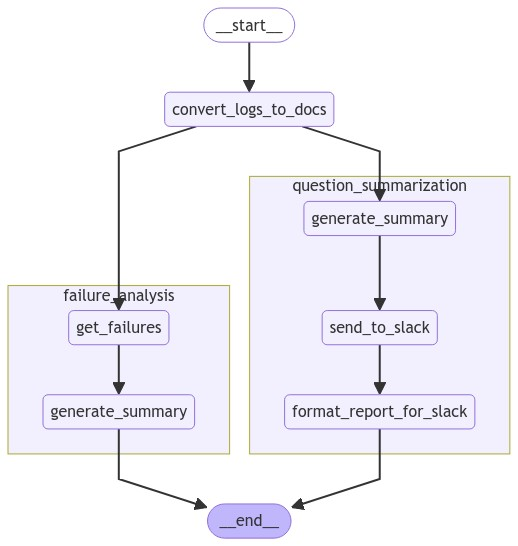

In [13]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
raw_logs = [{"foo": "bar"}, {"foo": "baz"}]
result = graph.invoke({"raw_logs": raw_logs}, debug=False)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


👆 LangSmith trace: https://smith.langchain.com/public/130615d0-542e-4296-8a4f-07ce7dba42c7/r

In [17]:
import json

# Prettify JSON
pretty_json = json.dumps(result, indent=4)
print(pretty_json)

{
    "raw_logs": [
        {
            "foo": "bar"
        },
        {
            "foo": "baz"
        }
    ],
    "docs": [
        {
            "id": "1",
            "question": "How can I import ChatOllama?",
            "answer": "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"
        },
        {
            "id": "2",
            "question": "How can I use Chroma vector store?",
            "answer": "To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
            "grade": 0,
            "grader": "Document Relevance Recall",
            "feedback": "The retrieved documents discuss vector stores in general, but not Chroma specifically"
        },
        {
            "id": "1",
            "question": "How can I import ChatOllama?",
            "answer": "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"
        },
        {
            "id": "2",
      

## 通过邮包来实现 MapReduce

> 官方指南：https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

[MapReduce](https://en.wikipedia.org/wiki/MapReduce) 对于高效的任务分解和并行处理很有帮助。这种方法将任务分解成更小的子任务，并行处理每个子任务，并将所有完成子任务的结果汇总。

让我们想象一下这个例子：给定用户的一个通用主题，生成一系列相关主题，为每个主题生成一个笑话，并从结果中选择最佳的笑话。在这个设计中，第一个节点可能生成一个对象列表（例如，相关主题），我们希望将某些其他节点（例如，生成笑话）应用于所有这些对象（例如，主题）。然而，出现了两个主要挑战：

1. 在构建图时，对象（例如“主题”）的数量可能事先未知（意味着边的数量可能未知）；
1. 输入到下游节点的状态应不同（每个下游节点都会得到一个不同的主题）。

<img src="assets/images/mapreduce.png" width="" align="" />

对于这种场景，LangGraph 通过其 [`Send` API](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) 解决这些挑战。

> `Send` 类在 `StateGraph` 的条件边中使用，以在下一步动态调用具有自定义状态的节点。
> 
> 重要的是，发送状态可以与核心图的状态可以不同，从而允许灵活和动态的工作流程管理。它接受两个参数：
> - `node` (`str`)：要发送消息的目标节点的名称
> - `arg`（`Any`）：要发送到目标节点的状态或消息

通过利用条件边（Conditional Edge）， `Send` 可以将不同的状态（例如，主题）分配给节点的多个实例（例如，生成笑话）。重要的是，**发送的状态可以与核心图的状态不同**，从而实现灵活和动态的工作流程管理。

In [19]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
model = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)

In [20]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    # Load subject data from `Send` state object
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

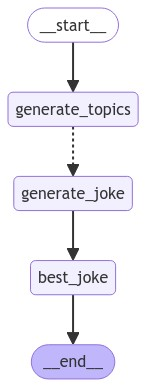

In [21]:
from IPython.display import Image

Image(app.get_graph(xray=1).draw_mermaid_png())

In [23]:
# Call the graph: here we call it to generate a list of jokes
for chunk in app.stream({"topic": "animals"}):
    print(chunk)

{'generate_topics': {'subjects': ['lion', 'elephant', 'giraffe', 'zebra', 'tiger']}}
{'generate_joke': {'jokes': ["Why don't lions play cards in the jungle? Because there are too many cheetahs!"]}}
{'generate_joke': {'jokes': ["Why don't giraffes like fast food? Because they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? Because they're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ['Why did the tiger eat the tightrope walker? Because he wanted a well-balanced meal!']}}
{'generate_joke': {'jokes': ['Why do zebras always get good grades? Because they have great stripes!']}}
{'best_joke': {'best_selected_joke': "Why don't elephants use computers? Because they're afraid of the mouse!"}}


👆 LangSmith trace: https://smith.langchain.com/public/42ec2fb8-7296-4539-abd1-e445326899ae/r

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6124301-0a3c-4c43-a70b-884a597351fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>